📄 Node 속성 컬럼:
Index(['node_id', 'geometry'], dtype='object')

📄 Edge 속성 컬럼:
Index(['edge_id', 'journeys', 'from_node_', 'to_node_id', 'geometry'], dtype='object')

🔍 toy_node 샘플:
   node_id                        geometry
0        1  POINT (950932.279 6464069.251)
1        2   POINT (929545.044 6447020.87)
2        3  POINT (943823.639 6450947.638)
3        4   POINT (961732.262 6466902.52)
4        5   POINT (961048.66 6458100.124)

🔍 toy_edge 샘플:
   edge_id  journeys  from_node_  to_node_id  \
0        1      8000           2          39   
1        2      9000          39          34   
2        3      8000          34          37   
3        4      7000          37          40   
4        5      8000          40          38   

                                            geometry  
0  LINESTRING (929545.044 6447020.87, 930424.011 ...  
1  LINESTRING (930424.011 6445054.267, 944715.564...  
2  LINESTRING (944715.564 6433250.593, 948079.16 ...  
3  LINESTRING (948079.16 6432406.653, 

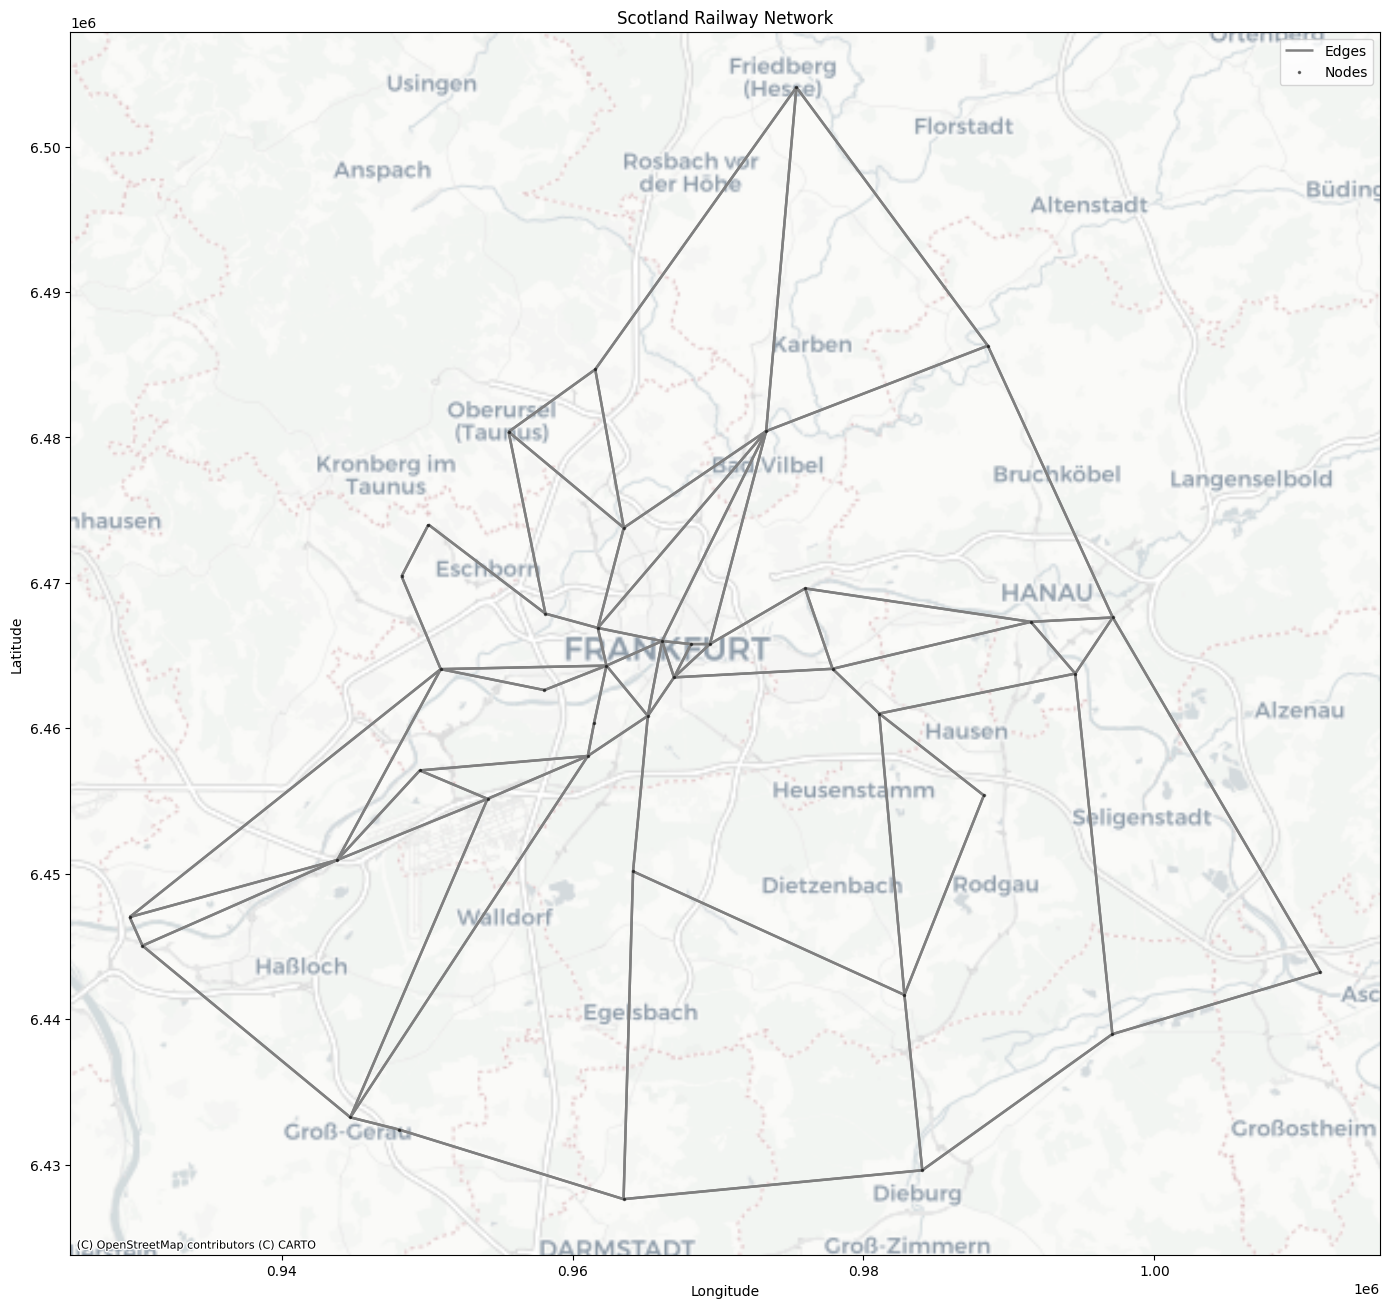

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString
import pandas as pd
import time

start_time = time.time() 

# Define file paths
toy_node_path = r"D:\MINJI\NETWORK RELIABILITY\Data\datafiles\used\toy_node.shp"
toy_edge_path = r"D:\MINJI\NETWORK RELIABILITY\Data\datafiles\used\toy_edge.shp"

# Load the shapefiles
toy_node = gpd.read_file(toy_node_path)
toy_edge = gpd.read_file(toy_edge_path)

# Convert CRS to Web Mercator (EPSG:3857) for basemap compatibility
toy_edge = toy_edge.set_crs(epsg=4326)  # 👉 당신의 실제 EPSG 코드로 바꿔줘야 함
toy_edge = toy_edge.to_crs(epsg=3857)
toy_node = toy_node.to_crs(epsg=3857)

print("📄 Node 속성 컬럼:")
print(toy_node.columns)

print("\n📄 Edge 속성 컬럼:")
print(toy_edge.columns)

# 예시: 일부 데이터 확인
print("\n🔍 toy_node 샘플:")
print(toy_node.head())

print("\n🔍 toy_edge 샘플:")
print(toy_edge.head())

# Create a plot with network and basemap
fig, ax = plt.subplots(figsize=(14, 14))
toy_edge.plot(ax=ax, color="grey", linewidth=1.8, label="Edges")

node_coords = toy_node.geometry.apply(lambda pt: (pt.x, pt.y)).tolist()
x_coords, y_coords = zip(*node_coords)
ax.scatter(x_coords, y_coords, color="black", s=2.3, label="Nodes", zorder=3, alpha=0.5)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zorder=0)
plt.legend()
plt.title("Scotland Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

====== Node info ======
n1 (ID: 2): (929545.043663, 6447020.87033)
n2 (ID: 39): (930424.01123, 6445054.267456)
n3 (ID: 3): (943823.638525, 6450947.638076)
n4 (ID: 34): (944715.563681, 6433250.592834)
n5 (ID: 37): (948079.16, 6432406.653)
n6 (ID: 31): (948241.1299, 6470452.383)
n7 (ID: 33): (949497.259, 6457105.0497)
n8 (ID: 8): (950087.0297, 6474006.9428)
n9 (ID: 1): (950932.2786, 6464069.2507)
n10 (ID: 17): (954147.2968, 6455150.7991)
n11 (ID: 18): (955599.225768, 6480388.014611)
n12 (ID: 10): (958059.3976, 6462628.8843)
n13 (ID: 11): (958129.7516, 6467884.9984)
n14 (ID: 5): (961048.6599, 6458100.1237)
n15 (ID: 26): (961474.7909, 6460364.5426)
n16 (ID: 24): (961554.818525, 6484676.384155)
n17 (ID: 4): (961732.261794, 6466902.520267)
n18 (ID: 21): (962325.8285, 6464311.5345)
n19 (ID: 40): (963502.675843, 6427628.428361)
n20 (ID: 13): (963518.1715, 6473785.0532)
n21 (ID: 12): (964155.965407, 6450163.965978)
n22 (ID: 20): (965170.753885, 6460852.093469)
n23 (ID: 19): (966153.148391, 6466

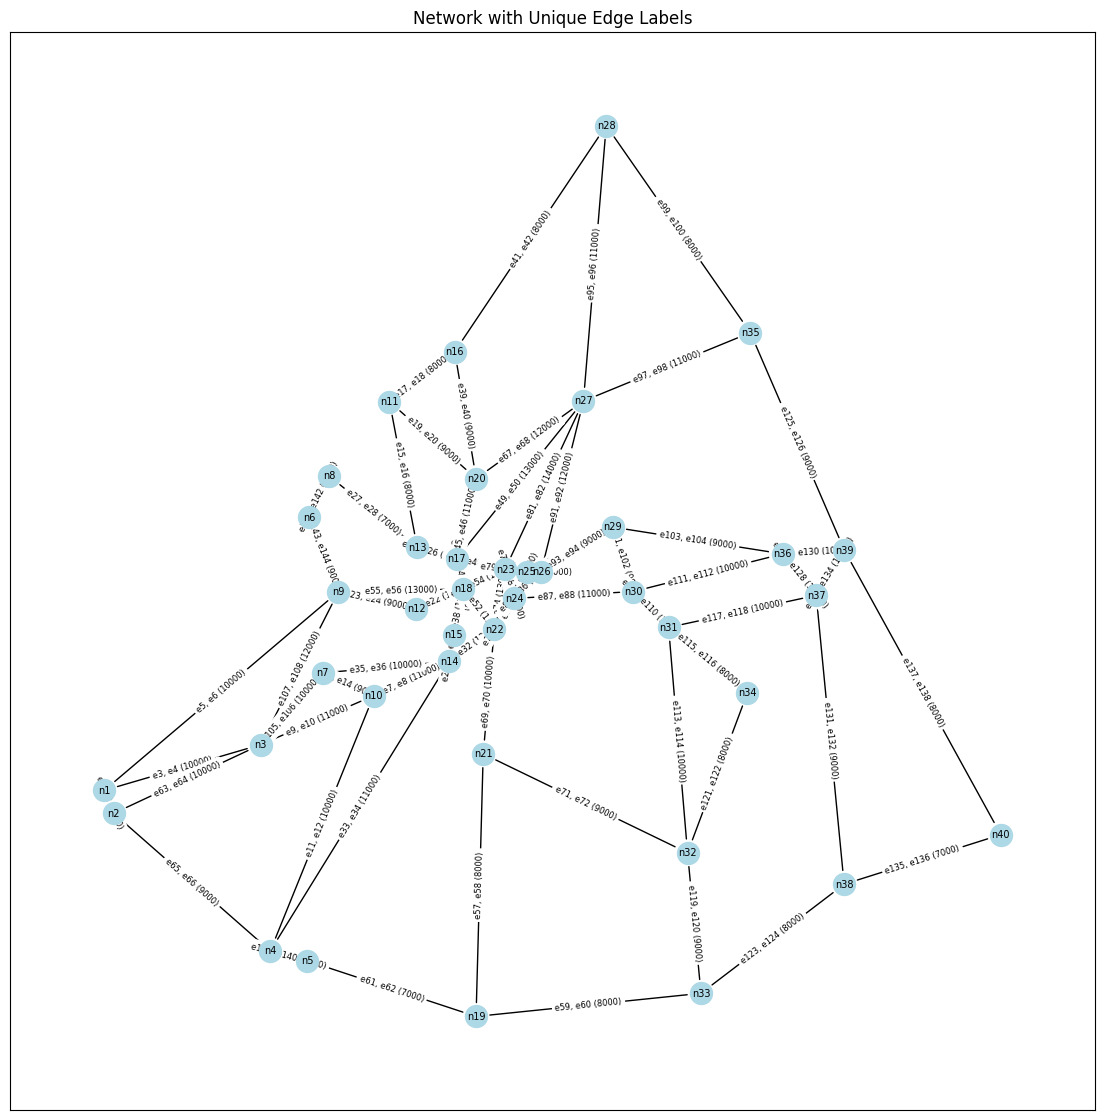

In [2]:
import networkx as nx



# 1. Node numbering (n1, n2, ...)
round_coord = lambda coord: (round(coord[0], 6), round(coord[1], 6))

node_info_list = [
    (row.node_id, round_coord((row.geometry.x, row.geometry.y)))
    for row in toy_node.itertuples()
]

sorted_node_info = sorted(node_info_list, key=lambda x: (x[1][0], -x[1][1]))

nodes = {}  
node_meta = [] 

for idx, (node_id, coord) in enumerate(sorted_node_info):
    node_name = f"n{idx + 1}"
    nodes[node_name] = coord
    node_meta.append({
        "node_id": node_id,
        "node_name": node_name,
        "geometry": coord  
    })

coord_to_node = {coord: node_name for node_name, coord in nodes.items()}

print("====== Node info ======")
for meta in node_meta:
    print(f"{meta['node_name']} (ID: {meta['node_id']}): {meta['geometry']}")



# 2. Edge numbering (e1, e2, ...)
nodeid_to_nodename = {meta["node_id"]: meta["node_name"] for meta in node_meta}
toy_edge['from_node_name'] = toy_edge['from_node_'].map(nodeid_to_nodename)
toy_edge['to_node_name'] = toy_edge['to_node_id'].map(nodeid_to_nodename)

edge_pairs = set()

for _, row in toy_edge.iterrows():
    from_node = row['from_node_name']
    to_node = row['to_node_name']
    sorted_pair = tuple(sorted([from_node, to_node]))
    edge_pairs.add(sorted_pair)

sorted_edge_pairs = sorted(edge_pairs, key=lambda x: (x[0], x[1]))
print(sorted_edge_pairs)

edges = {}
edge_number = 1

for from_node, to_node in sorted_edge_pairs:
    edges[f"e{edge_number}"] = (from_node, to_node)
    edges[f"e{edge_number + 1}"] = (to_node, from_node)
    edge_number += 2

edge_records = []
for edge_name, (from_node, to_node) in edges.items():
    match = toy_edge[((toy_edge['from_node_name'] == from_node) & (toy_edge['to_node_name'] == to_node)) |
                     ((toy_edge['from_node_name'] == to_node) & (toy_edge['to_node_name'] == from_node))]
    
    if not match.empty:
        journeys = match.iloc[0]['journeys']
        geometry = match.iloc[0]['geometry']
        edge_id = match.iloc[0]['edge_id']
    else:
        journeys = None
        geometry = None
        edge_id = None

    edge_records.append({
        'edge_id': edge_id,
        'edge_name': edge_name,
        'from_node_name': from_node,
        'to_node_name': to_node,
        'journeys': journeys,
        'geometry': geometry
    })

toy_edge_bidirectional = pd.DataFrame(edge_records)

toy_edge_bidirectional['edge_num'] = toy_edge_bidirectional['edge_name'].str.extract(r'e(\d+)').astype(int)
toy_edge_bidirectional = toy_edge_bidirectional.sort_values(by='edge_num').reset_index(drop=True)
toy_edge_bidirectional = toy_edge_bidirectional.drop(columns='edge_num')

print("\n====== Edge info ======")
pd.set_option('display.max_rows', None)
print(toy_edge_bidirectional)



# 3. Convert edges to arc format
arcs = [(u, v) for _, (u, v) in edges.items()]
#print("\nArcs:", arcs)



# 4. Compute Euclidean distances
def euclidean_distance(node1, node2):
    x1, y1 = nodes[node1]
    x2, y2 = nodes[node2]
    return round(((x2 - x1)**2 + (y2 - y1)**2)**0.5, 2)

arc_distance = {edge_name: euclidean_distance(u, v) for edge_name, (u, v) in edges.items()}
#print("Arc Distances:", arc_distance)



# 5. Create a network graph
# Create the graph using extracted data
G = nx.DiGraph()

# Add nodes and edges
for node, position in nodes.items():
    G.add_node(node, pos=position)

for edge_name, (u, v) in edges.items(): 
    G.add_edge(u, v, weight=arc_distance[edge_name])

# Remove duplicate edges
unique_edges = set()
edge_name_map = {}

for edge_name, (u, v) in edges.items():
    if (v, u) not in unique_edges:
        unique_edges.add((u, v))
        
        reverse_edge_name = [k for k, (a, b) in edges.items() if (a, b) == (v, u)]
        if reverse_edge_name:
            journeys = toy_edge_bidirectional[
                (toy_edge_bidirectional['from_node_name'] == u) &
                (toy_edge_bidirectional['to_node_name'] == v)
            ]['journeys'].values

            journeys_val = int(journeys[0]) if len(journeys) > 0 else "?"
            edge_label = f"{edge_name}, {reverse_edge_name[0]} ({journeys_val})"
        else:
            edge_label = edge_name

        edge_name_map[(u, v)] = edge_label


# Plot the network topology
plt.figure(figsize=(14, 14))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=250, node_color="lightblue")
nx.draw_networkx_edges(
    G, pos,
    edgelist=list(unique_edges),  
    arrowstyle='-',
    min_target_margin=10,
    min_source_margin=10
)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_name_map, font_size=6)
nx.draw_networkx_labels(G, pos, font_size=7)
plt.title("Network with Unique Edge Labels")
plt.show()



import re
import json
import networkx as nx

# 1. raw 경고 메시지를 리스트로 입력 (예: log_str에 저장)
log_lines = """
⚠️ Edge n1 → n9 (arc: e5) had no flow, capacity = 10000
⚠️ Edge n9 → n1 (arc: e5) had no flow, capacity = 10000
⚠️ Edge n3 → n10 (arc: e9) had no flow, capacity = 11000
⚠️ Edge n16 → n11 (arc: e17) had no flow, capacity = 8000
⚠️ Edge n20 → n11 (arc: e19) had no flow, capacity = 9000
⚠️ Edge n12 → n9 (arc: e23) had no flow, capacity = 9000
⚠️ Edge n9 → n12 (arc: e23) had no flow, capacity = 9000
⚠️ Edge n8 → n13 (arc: e27) had no flow, capacity = 7000
⚠️ Edge n14 → n15 (arc: e29) had no flow, capacity = 9000
⚠️ Edge n14 → n4 (arc: e33) had no flow, capacity = 11000
⚠️ Edge n14 → n7 (arc: e35) had no flow, capacity = 10000
⚠️ Edge n7 → n14 (arc: e35) had no flow, capacity = 10000
⚠️ Edge n16 → n20 (arc: e39) had no flow, capacity = 9000
⚠️ Edge n20 → n16 (arc: e39) had no flow, capacity = 9000
⚠️ Edge n16 → n28 (arc: e41) had no flow, capacity = 8000
⚠️ Edge n17 → n27 (arc: e49) had no flow, capacity = 13000
⚠️ Edge n21 → n19 (arc: e57) had no flow, capacity = 8000
⚠️ Edge n19 → n33 (arc: e59) had no flow, capacity = 8000
⚠️ Edge n33 → n19 (arc: e59) had no flow, capacity = 8000
⚠️ Edge n2 → n3 (arc: e63) had no flow, capacity = 10000
⚠️ Edge n3 → n2 (arc: e63) had no flow, capacity = 10000
⚠️ Edge n2 → n4 (arc: e65) had no flow, capacity = 9000
⚠️ Edge n23 → n22 (arc: e73) had no flow, capacity = 13000
⚠️ Edge n23 → n27 (arc: e81) had no flow, capacity = 14000
⚠️ Edge n28 → n35 (arc: e99) had no flow, capacity = 8000
⚠️ Edge n9 → n3 (arc: e107) had no flow, capacity = 12000
⚠️ Edge n31 → n32 (arc: e113) had no flow, capacity = 10000
⚠️ Edge n34 → n32 (arc: e121) had no flow, capacity = 8000
⚠️ Edge n33 → n38 (arc: e123) had no flow, capacity = 8000
⚠️ Edge n35 → n39 (arc: e125) had no flow, capacity = 9000
⚠️ Edge n38 → n40 (arc: e135) had no flow, capacity = 7000
⚠️ Edge n8 → n6 (arc: e141) had no flow, capacity = 6000
""".strip().splitlines()

# 2. G는 이미 구성된 networkx.DiGraph이며, arc_distance 등도 준비돼 있어야 함
# 예: G = nx.DiGraph(); G.add_node(...); G.add_edge(..., weight=arc_distance[e])

new_demand = []

for line in log_lines:
    match = re.search(r"Edge (n\d+) → (n\d+).*capacity\s*=\s*(\d+)", line)
    if match:
        origin_name = match.group(1)
        dest_name = match.group(2)
        capacity = int(match.group(3))
        journeys = round(capacity * 0.9)

        try:
            # distance 계산 (최단거리)
            distance = nx.shortest_path_length(G, source=origin_name, target=dest_name, weight='weight')
        except nx.NetworkXNoPath:
            print(f"❌ No path between {origin_name} and {dest_name}, skipping...")
            continue

        # node 번호만 뽑기 (예: 'n8' → '8')
        origin = origin_name[1:]
        dest = dest_name[1:]

        new_demand.append({
            "origin": origin,
            "destination": dest,
            "distance": distance,
            "journeys": journeys,
            "origin_name": origin_name,
            "destination_name": dest_name
        })

# 3. 저장
with open(r"D:\MINJI\NETWORK RELIABILITY\code\demand_data.json", "w") as f:
    json.dump(new_demand, f, indent=4)

print(f"✅ {len(new_demand)} OD pairs saved to demand_data.json")


In [3]:
import sys
import os
import gc
import re
import json
import copy

# Scientific Libraries
import numpy as np
from scipy.stats import beta

# Optimization
from gurobipy import Model, GRB, quicksum

# Graph & Plotting\
import matplotlib
matplotlib.use("Agg")

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

# MBNpy Modules
import matplotlib
matplotlib.use("Agg")  # GUI 없는 환경에서도 작동하는 안전한 backend
from mbnpy import brc, cpm, variable, operation, branch, config

# Local Module
import batch

# Clean up memory
gc.collect()
%matplotlib inline


C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_37872\4198701244.py:26: DeprecationWarning: operation.py is deprecated and replaced with inference.py. Please update your imports.
  from mbnpy import brc, cpm, variable, operation, branch, config


In [4]:
nodes = nodes  
edges = edges  
arcs = arcs
arc_distance = arc_distance 



# 1. Generate arc failure probabilities based on arc distances (longer distance -> higher failure probability)
# Get the minimum and maximum arc distances
min_dist = min(arc_distance.values())
max_dist = max(arc_distance.values())

# Failure probability range (0.01 ~ 0.3)
min_prob = 0.01
max_prob = 0.3

def compute_failure_probability(distance, min_dist, max_dist, min_prob, max_prob):
    normalized_dist = (distance - min_dist) / (max_dist - min_dist) # Normalize to [0,1]
    return round(min_prob + normalized_dist * (max_prob - min_prob), 4)

# Generate failure probability for each edge
probs_dynamic = {
    edge: {
        0: compute_failure_probability(dist, min_dist, max_dist, min_prob, max_prob),
        1: round(1 - compute_failure_probability(dist, min_dist, max_dist, min_prob, max_prob), 4)
    }
    for edge, dist in arc_distance.items()
}

# Sort edges by numeric order
def numeric_sort(edge):
    return int(edge[1:])  # Extract numeric part from "eX"

probs_sorted = {k: probs_dynamic[k] for k in sorted(probs_dynamic, key=numeric_sort)}

# Print formatted probabilities
#print(json.dumps(probs_sorted, indent=4, separators=(",", ": ")))
probs = probs_sorted
probs_cpm = copy.deepcopy(probs)
#print(probs_cpm)



# 2. Assign capacities to each arcs
# Initial intact capacity (Unchanged from original)
intact_capacity = {}

for edge_name, (u, v) in edges.items():
    match = toy_edge[((toy_edge['from_node_name'] == u) & (toy_edge['to_node_name'] == v)) |
                     ((toy_edge['from_node_name'] == v) & (toy_edge['to_node_name'] == u))]

    if not match.empty:
        intact_capacity[edge_name] = match.iloc[0]['journeys']
    else:
        intact_capacity[edge_name] = None  

print("Intact Capacities:", intact_capacity)

# Function to generate random component states (0 or 1) based on failure probabilities
def generate_comps_st(probs):
    comps_st = {}

    for edge, prob in probs.items():
        if isinstance(prob, dict) and 0 in prob and 1 in prob:  # Ensure correct structure
            comps_st[edge] = np.random.choice([0, 1], p=[prob[0], prob[1]])
        else:
            print(f"Warning: Invalid probability format for edge {edge}: {prob}")  

    return comps_st

# Compute arc capacities
comps_st = generate_comps_st(probs_sorted)  



# 3. Compute maximum allowable distance
# Demand data
json_path = r"D:\MINJI\NETWORK RELIABILITY\Data\datafiles\used\demand_data2_updated.json"
with open(json_path, "r", encoding="utf-8") as f:
    demand = json.load(f)

# Compute max allowable distance
avg_velo = 149  # Speed in km/h
max_distance = {}
commodity_name_map = {}  

for idx, item in enumerate(demand, start=1):
    origin = item["origin"]
    destination = item["destination"]
    commodity_key = f"{origin}->{destination}"
    commodity_name = f"k{idx}"  

    distance = item["distance"]
    max_allowable_time = (distance * 60) / avg_velo + 180
    max_distance[commodity_name] = max_allowable_time * avg_velo / 60

    commodity_name_map[commodity_name] = {
        "key": commodity_key,
        "origin": origin,
        "destination": destination
    }

    print(f"\nCommodity: {commodity_name}")
    print(f"  OD Pair: {commodity_key}")
    print(f"  Distance (from JSON): {distance:.2f} km")
    print(f"  Maximum allowable time: {max_allowable_time:.2f} minutes")
    print(f"  Maximum allowable distance: {max_distance[commodity_name]:.2f} km")

Intact Capacities: {'e1': np.int64(8000), 'e2': np.int64(8000), 'e3': np.int64(10000), 'e4': np.int64(10000), 'e5': np.int64(10000), 'e6': np.int64(10000), 'e7': np.int64(11000), 'e8': np.int64(11000), 'e9': np.int64(11000), 'e10': np.int64(11000), 'e11': np.int64(10000), 'e12': np.int64(10000), 'e13': np.int64(9000), 'e14': np.int64(9000), 'e15': np.int64(8000), 'e16': np.int64(8000), 'e17': np.int64(8000), 'e18': np.int64(8000), 'e19': np.int64(9000), 'e20': np.int64(9000), 'e21': np.int64(10000), 'e22': np.int64(10000), 'e23': np.int64(9000), 'e24': np.int64(9000), 'e25': np.int64(10000), 'e26': np.int64(10000), 'e27': np.int64(7000), 'e28': np.int64(7000), 'e29': np.int64(9000), 'e30': np.int64(9000), 'e31': np.int64(12000), 'e32': np.int64(12000), 'e33': np.int64(11000), 'e34': np.int64(11000), 'e35': np.int64(10000), 'e36': np.int64(10000), 'e37': np.int64(10000), 'e38': np.int64(10000), 'e39': np.int64(9000), 'e40': np.int64(9000), 'e41': np.int64(8000), 'e42': np.int64(8000), '

🟦 OD n7 → n23, amount=1510 ➜ edge ('n7', 'n14') += 1510 (total: 1510)
🟦 OD n7 → n23, amount=1510 ➜ edge ('n14', 'n22') += 1510 (total: 1510)
🟦 OD n7 → n23, amount=1510 ➜ edge ('n22', 'n23') += 1510 (total: 1510)
🟦 OD n38 → n32, amount=290 ➜ edge ('n38', 'n33') += 290 (total: 290)
🟦 OD n38 → n32, amount=290 ➜ edge ('n33', 'n32') += 290 (total: 290)
🟦 OD n5 → n13, amount=1580 ➜ edge ('n5', 'n4') += 1580 (total: 1580)
🟦 OD n5 → n13, amount=1580 ➜ edge ('n4', 'n14') += 1580 (total: 1580)
🟦 OD n5 → n13, amount=1580 ➜ edge ('n14', 'n15') += 1580 (total: 1580)
🟦 OD n5 → n13, amount=1580 ➜ edge ('n15', 'n18') += 1580 (total: 1580)
🟦 OD n5 → n13, amount=1580 ➜ edge ('n18', 'n17') += 1580 (total: 1580)
🟦 OD n5 → n13, amount=1580 ➜ edge ('n17', 'n13') += 1580 (total: 1580)
🟦 OD n5 → n16, amount=1730 ➜ edge ('n5', 'n4') += 1730 (total: 3310)
🟦 OD n5 → n16, amount=1730 ➜ edge ('n4', 'n14') += 1730 (total: 3310)
🟦 OD n5 → n16, amount=1730 ➜ edge ('n14', 'n15') += 1730 (total: 3310)
🟦 OD n5 → n16, am

C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_37872\2382594582.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


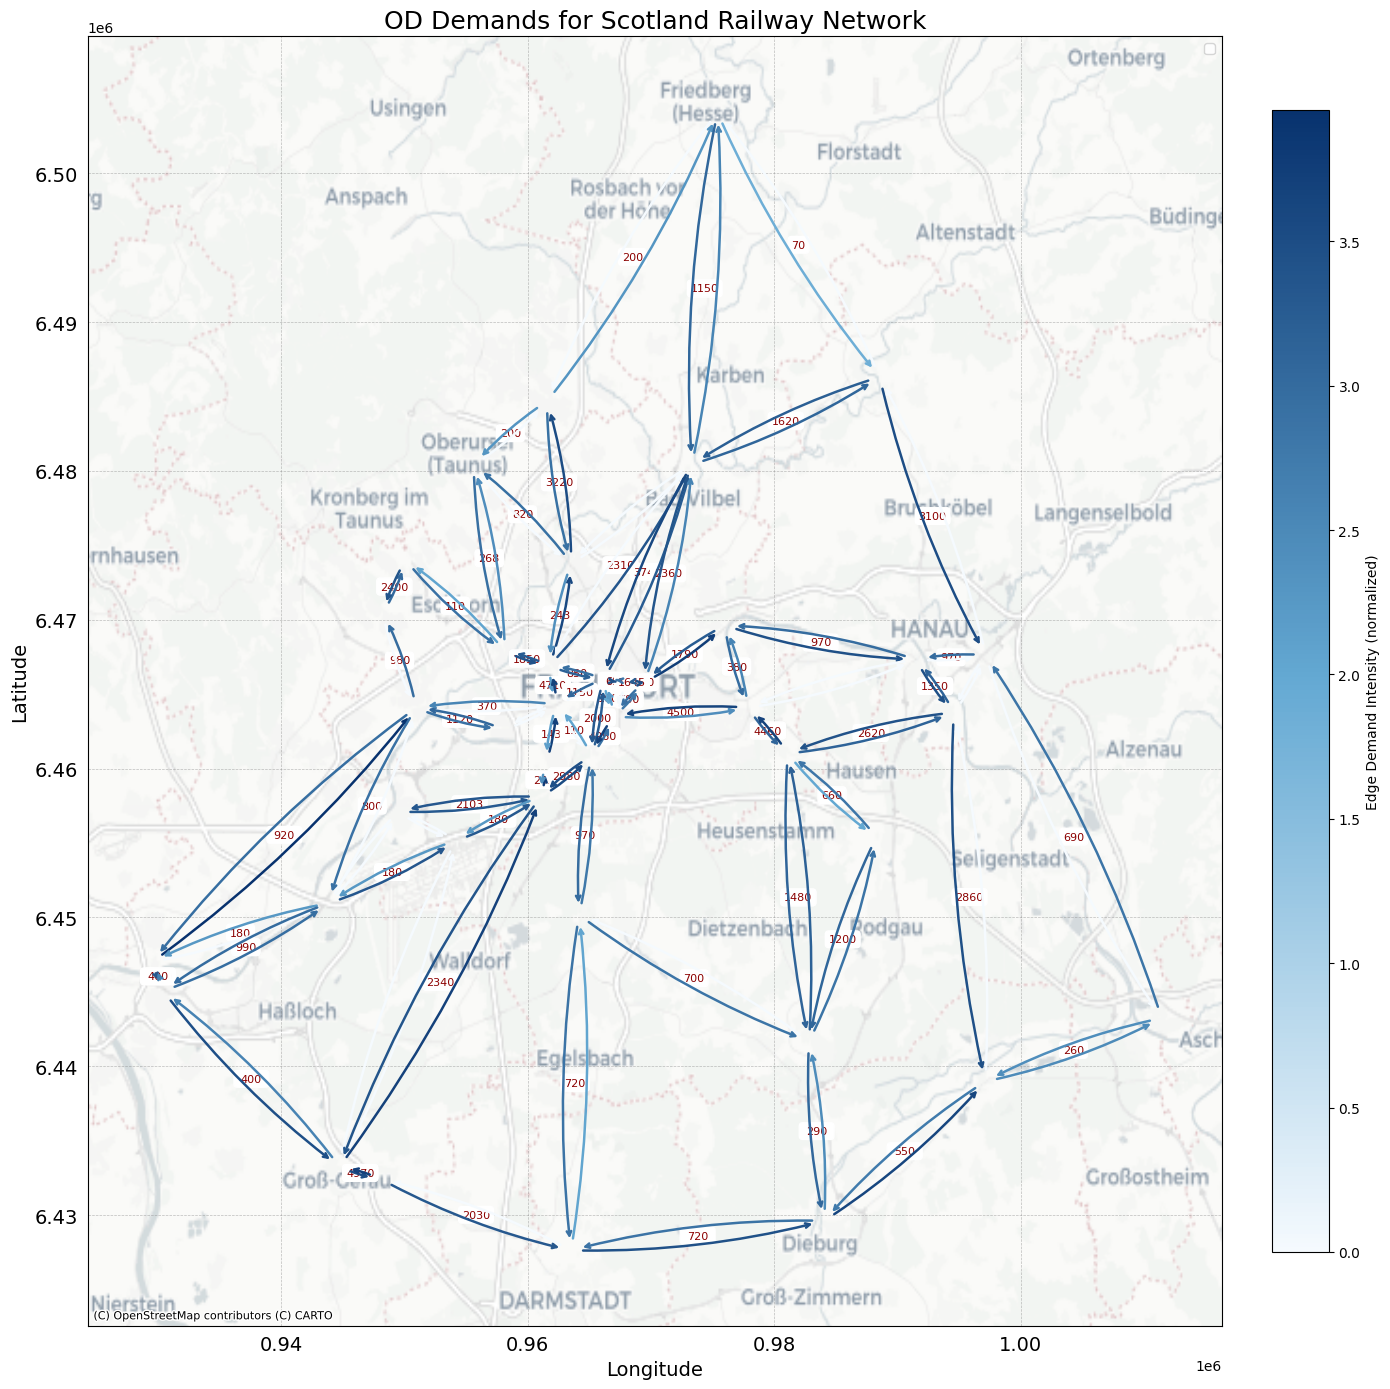

In [5]:
# Build directed graph with weighted arcs
G = nx.DiGraph()
for node, position in nodes.items():
    G.add_node(node, pos=position)

for edge_id, (u, v) in edges.items():
    G.add_edge(u, v, weight=arc_distance[edge_id])

# Initialize demand for each arc
edge_demand = { (u, v): 0 for u, v in G.edges }

# Accumulate demand from all shortest paths
for info in demand:
    origin = info["origin_name"]         # use node name like 'n18'
    destination = info["destination_name"]
    amount = info["journeys"]            # amount is stored as 'journeys'

    try:
        paths = list(nx.all_shortest_paths(G, source=origin, target=destination, weight="weight"))
        for path in paths:
            for i in range(len(path) - 1):
                edge = (path[i], path[i + 1])
                if edge in edge_demand:
                    edge_demand[edge] += amount
                    print(f"🟦 OD {origin} → {destination}, amount={amount} ➜ edge {edge} += {amount} (total: {edge_demand[edge]})")
    except nx.NetworkXNoPath:
        print(f"⚠️ No path found for {origin} → {destination}")
        continue

# Log-scaled normalization
normalized_demand = {
    (u, v): np.log10(d + 1) for (u, v), d in edge_demand.items()
}
D_max = max(normalized_demand.values())
D_min = min(normalized_demand.values())

normalized_demand = {
    (u, v): (val - D_min) / (D_max - D_min)
    for (u, v), val in normalized_demand.items()
}

# Visualization
from matplotlib.colors import LinearSegmentedColormap
start_rgb = (245/255, 250/255, 254/255)    
mid_rgb   = (100/255, 169/255, 211/255)       
end_rgb   = (8/255, 50/255, 110/255)    
cmap = LinearSegmentedColormap.from_list("custom_3color_gradient", [start_rgb, mid_rgb, end_rgb])

pos = nx.get_node_attributes(G, "pos")
fig, ax = plt.subplots(figsize=(14, 14))

# Nodes
# ✅ 2. 라벨 시각화 (normalized demand 그리는 코드 이후에 삽입)

# ✅ 1. 엣지 라벨 정의 (값이 0보다 큰 경우만 표시)
edge_labels = {
    (u, v): f"{edge_demand[(u, v)]:.0f}"
    for (u, v) in G.edges
    if edge_demand[(u, v)] > 0
}

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=edge_labels,
    font_size=8,
    font_color="darkred",
    rotate=False,
    ax=ax
)


# Edges with normalized demand
for (u, v), value in normalized_demand.items():
    color = cmap(value)
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)],
        width=1.8,
        edge_color=[color],
        arrowstyle="->",
        arrowsize=8,
        alpha=1,
        ax=ax,
        connectionstyle="arc3,rad=0.07"
    )

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs="EPSG:3857", zorder=0)
ax.tick_params(labelbottom=True, labelleft=True)
ax.set_axis_on()
ax.ticklabel_format(useOffset=False)

# Colorbar
norm = mpl.colors.Normalize(vmin=D_min, vmax=D_max)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Edge Demand Intensity (normalized)")

# Grid
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=14, direction='out')
ax.set_axisbelow(True)  

plt.title("OD Demands for Scotland Railway Network", fontsize=18)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
def MCNF_od_systemfunc(arcs, comps_st, edges, arc_capacity, demand,max_distance, arc_distance, target_od):
    
    from gurobipy import Model, GRB, quicksum
    import networkx as nx

    # Construct a graph for shortest path calculations
    G = nx.Graph()
    for e, (i, j) in edges.items():
        G.add_edge(i, j, weight=arc_distance.get(e, 1)) 

    # Create Gurobi model
    model = Model("Network Flow Optimization")
    model.setParam('OutputFlag', 0) 

    # Define decision variables
    flow = {}
    unmet_demand = {}

    for k, info in demand.items():
        unmet_demand[k] = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"unsatisfied_{k}")
        for i, j in arcs:
            arc_key = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
            capacity = arc_capacity.get(arc_key, 0)
            flow[k, i, j] = model.addVar(lb=0, ub=capacity, vtype=GRB.CONTINUOUS, name=f"flow_{k}_{i}_{j}")

    # Objective: minimize total unmet demand
    model.setObjective(
        quicksum(unmet_demand[k] for k in demand),
        GRB.MINIMIZE
    )

    nodes = set(node for edge in edges.values() for node in edge)

    # Constraint 1: Flow conservation
    for k, info in demand.items():
        origin = info['origin']
        destination = info['destination']
        amount = info['amount']
        for node in nodes: 
            inflow = quicksum(flow[k, i, j] for i, j in arcs if j == node)
            outflow = quicksum(flow[k, i, j] for i, j in arcs if i == node)
            if node == origin:
                model.addConstr(outflow - inflow == amount - unmet_demand[k])
            elif node == destination:
                model.addConstr(outflow - inflow == - amount + unmet_demand[k])
            else:
                model.addConstr(outflow - inflow == 0)

    # Constraint 2: Arc capacity limits
    for i, j in arcs:
        arc_key = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
        model.addConstr(quicksum(flow[k, i, j] for k in demand if (k, i, j) in flow) <= arc_capacity.get(arc_key, 0))

    # Constraint 3: Distance constraints for each commodity
    for k, info in demand.items():
        origin = info['origin']
        distance_expr = quicksum(arc_distance.get(e, 0) * flow[k, i, j] for e, (i, j) in edges.items() if (k, i, j) in flow)
        total_flow = quicksum(flow[k, i, j] for i, j in arcs if (k, i, j) in flow and i == origin)
        
        model.addConstr(distance_expr <= max_distance[k] * total_flow)

    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        origin = demand[target_od]['origin']
        destination = demand[target_od]['destination']
        amount = demand[target_od]['amount']

        # Sum of flow into destination
        flow_to_dest = sum(
            flow[target_od, i, destination].x
            for i, j in arcs
            if j == destination and (target_od, i, j) in flow
        )

        flow_ratio = flow_to_dest / amount if amount > 0 else 0
        if flow_ratio > 0.9:
            sys_st = 's'

            min_comps_st = {}
            for (k, i, j), var in flow.items():
                if k == target_od and var.x > 0:
                    link_name = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
                    if link_name:
                        min_comps_st[link_name] = 1

        else:
            sys_st = 'f'
            min_comps_st = None    
        
        print(f"Used Components: {min_comps_st}")

        return flow_ratio, sys_st, min_comps_st
    
    else:
        return None, None, None

In [7]:
def MCNF_systemfunc(arcs, comps_st, edges, arc_capacity, demand, max_distance, arc_distance):
    from gurobipy import Model, GRB, quicksum
    import networkx as nx

    # Create a graph for shortest path calculations
    G = nx.Graph()
    for e, (i, j) in edges.items():
        G.add_edge(i, j, weight=arc_distance.get(e, 1))  # Set edge weights based on distance

    # Create Gurobi optimization model
    model = Model("Network Flow Optimization")
    model.setParam('OutputFlag', 0) 

    # Define variables
    flow = {}
    unmet_demand = {}

    for k, info in demand.items():
        unmet_demand[k] = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"unsatisfied_{k}")
        for i, j in arcs:
            arc_key = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
            capacity = arc_capacity.get(arc_key, 0)
            flow[k, i, j] = model.addVar(lb=0, ub=capacity, vtype=GRB.CONTINUOUS, name=f"flow_{k}_{i}_{j}")

    # Objective function: Minimize expected loss
    model.setObjective(
        quicksum(unmet_demand[k] for k in demand),
        GRB.MINIMIZE
    )

    # Extract all nodes from edge values
    nodes = set(node for edge in edges.values() for node in edge)

    # Constraint 1: Flow conservation
    for k, info in demand.items():
        origin = info['origin']
        destination = info['destination']
        amount = info['amount']
        for node in nodes: 
            inflow = quicksum(flow[k, i, j] for i, j in arcs if j == node)
            outflow = quicksum(flow[k, i, j] for i, j in arcs if i == node)
            if node == origin:
                model.addConstr(outflow - inflow == amount - unmet_demand[k])
            elif node == destination:
                model.addConstr(outflow - inflow == - amount + unmet_demand[k])
            else:
                model.addConstr(outflow - inflow == 0)

    # Constraint 2: Arc capacity limits
    for i, j in arcs:
        arc_key = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
        model.addConstr(quicksum(flow[k, i, j] for k in demand if (k, i, j) in flow) <= arc_capacity.get(arc_key, 0))

    # Constraint 3: Commodity별 max_distance 적용
    for k, info in demand.items():
        origin = info['origin']
        distance_expr = quicksum(arc_distance.get(e, 0) * flow[k, i, j] for e, (i, j) in edges.items() if (k, i, j) in flow)
        total_flow = quicksum(flow[k, i, j] for i, j in arcs if (k, i, j) in flow and i == origin)
        
        model.addConstr(distance_expr <= max_distance[k] * total_flow)

    # Perform optimization
    model.optimize()

    # Process results
    if model.status == GRB.OPTIMAL:
        expected_loss = model.objVal

        total_demand = sum(info['amount'] for info in demand.values())
        expected_loss = max(0.0, min(expected_loss, total_demand))  # [0, total_demand] 범위로 보정


        # 추가한 코드
        print("\n📌 Unmet Demand per OD pair:")
        for k in demand:
            ud = unmet_demand[k].x
            if ud > 0:
                origin = demand[k]["origin"]
                dest = demand[k]["destination"]
                print(f"  🔴 {k}: {origin} → {dest}, unmet = {ud:.2f}")
        
        print("\n📌 Edges with zero flow (but available capacity):")
        for (i, j) in arcs:
            total_flow = sum(flow[k, i, j].x for k in demand if (k, i, j) in flow)
            arc_key = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
            capacity = arc_capacity.get(arc_key, 0)
            if total_flow == 0 and capacity > 0:
                print(f"  ⚠️ Edge {i} → {j} (arc: {arc_key}) had no flow, capacity = {capacity}")
        #여기까지


        if expected_loss < 318128.4:
            sys_st = 's'

            # We can infer an associated minimum survival rule in case of network connectivity.
            min_comps_st = {}

            # Extract used links from optimization result
            for (k, i, j), var in flow.items():
                if var.x > 0:  # If flow is greater than 0, the edge is used in the solution
                    link_name = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
                    if link_name:
                        min_comps_st[link_name] = 1  # Store as {e1: 1, e2: 1}

        else:
            sys_st = 'f'
            min_comps_st = None  # No survival rule needed for failed state
        
        num_failed_zero_capacity = sum(
            1 for comp, state in comps_st.items()
            if state == 0 and arc_capacity.get(comp, 1) == 0
        )

        return expected_loss, sys_st, total_demand 

    else:
        return None, None, None  

In [8]:
demand_dict = {}

for idx, item in enumerate(demand, start=1):
    key = f"k{idx}"
    demand_dict[key] = {
        "origin": item["origin_name"],
        "destination": item["destination_name"],
        "amount": item["journeys"],
        "distance": item["distance"]
    }

# 2. 모든 컴포넌트가 정상 상태
comps_st = {edge: 1 for edge in intact_capacity}

# 3. arc capacity 설정
arc_capacity = {edge: intact_capacity[edge] * comps_st[edge] for edge in intact_capacity}

# 4. MCNF 실행
expected_loss, sys_st, total_demand = MCNF_systemfunc(
    arcs=arcs,
    comps_st=comps_st,
    edges=edges,
    arc_capacity=arc_capacity,
    demand=demand_dict,
    max_distance=max_distance,
    arc_distance=arc_distance
)

# 5. 결과 출력
print("✅ Expected Loss:", expected_loss)
print("📌 System State:", sys_st)
print("📊 Total Demand:", total_demand)


Set parameter Username
Set parameter LicenseID to value 2637066
Academic license - for non-commercial use only - expires 2026-03-16

📌 Unmet Demand per OD pair:

📌 Edges with zero flow (but available capacity):
  ⚠️ Edge n1 → n2 (arc: e1) had no flow, capacity = 8000
  ⚠️ Edge n3 → n1 (arc: e3) had no flow, capacity = 10000
  ⚠️ Edge n14 → n10 (arc: e7) had no flow, capacity = 11000
  ⚠️ Edge n4 → n10 (arc: e11) had no flow, capacity = 10000
  ⚠️ Edge n11 → n16 (arc: e17) had no flow, capacity = 8000
  ⚠️ Edge n12 → n18 (arc: e21) had no flow, capacity = 10000
  ⚠️ Edge n18 → n12 (arc: e21) had no flow, capacity = 10000
  ⚠️ Edge n18 → n15 (arc: e37) had no flow, capacity = 10000
  ⚠️ Edge n28 → n16 (arc: e41) had no flow, capacity = 8000
  ⚠️ Edge n17 → n18 (arc: e43) had no flow, capacity = 13000
  ⚠️ Edge n27 → n17 (arc: e49) had no flow, capacity = 13000
  ⚠️ Edge n32 → n21 (arc: e71) had no flow, capacity = 9000
  ⚠️ Edge n24 → n23 (arc: e77) had no flow, capacity = 13000
  ⚠️ Edg

In [9]:
#### **OD마다 BRC 돌리는 코드**

import numpy as np

##### 결과 저장 딕셔너리
brc_results_by_od = {}

demand_dict = {}

for idx, item in enumerate(demand, start=1):
    key = f"k{idx}"
    demand_dict[key] = {
        "origin": item["origin_name"],
        "destination": item["destination_name"],
        "amount": item["journeys"],
        "distance": item["distance"]
    }
    
##### 각 OD에 대해 반복
for od_key in demand_dict:
    print(f"\n🔍 Running BRC for OD pair: {od_key} ...")

    sys_fun = lambda comps_st, od=od_key: MCNF_od_systemfunc(
    arcs=arcs, 
    comps_st=comps_st, 
    edges=edges, 
    arc_capacity={e: int(intact_capacity[e] * comps_st[e]) for e in comps_st},
    demand=demand_dict,
    max_distance=max_distance, 
    arc_distance=arc_distance, 
    target_od=od)

    # BRC 실행
    brs, rules, sys_res, monitor = brc.run(
        probs=probs,
        sys_fun=sys_fun,
        max_sf=np.inf,
        max_nb=np.inf,
        pf_bnd_wr=0.0,
        max_rules=30,
        active_decomp=10,
        display_freq=5,
        brs=[],
    )

    # 결과 정리
    P_f = sum(branch.p for branch in brs if branch.down_state == 'f')

    print(f"→ OD {od_key}: P_f = {P_f:.6f}")
    if len(rules['s'] + rules['f']) >= 100:
        print("⚠️  BRC stopped due to max_rules=100")

    # 저장
    brc_results_by_od[od_key] = {
        'brs': brs,
        'rules': rules,
        'P_f': P_f,
        'sys_res': sys_res,
        'monitor': monitor,
    }

    print(rules)



🔍 Running BRC for OD pair: k1 ...
Used Components: {'e29': 1, 'e35': 1, 'e37': 1, 'e43': 1, 'e49': 1, 'e53': 1, 'e81': 1}
Used Components: {'e31': 1, 'e35': 1, 'e73': 1, 'e75': 1, 'e77': 1}
Used Components: {'e7': 1, 'e13': 1, 'e29': 1, 'e37': 1, 'e53': 1}
Used Components: {'e13': 1, 'e43': 1, 'e47': 1, 'e55': 1, 'e105': 1, 'e107': 1}
Used Components: {'e7': 1, 'e9': 1, 'e31': 1, 'e75': 1, 'e77': 1, 'e105': 1}
[System function runs 5]..
The # of found non-dominated rules (f, s): 5 (0, 5)
Probability of branchs (f, s, u): (0.0000e+00, 9.81e-01, 1.9136e-02)
The # of branches (f, s, u), (min, avg) len of rf: 215 (0, 48, 167), (0, 0.00)
Elapsed seconds (average per round): 1.80e+00 (3.61e-01)
Used Components: {'e3': 1, 'e5': 1, 'e13': 1, 'e53': 1, 'e55': 1, 'e73': 1, 'e87': 1, 'e105': 1, 'e109': 1}
Used Components: {'e13': 1, 'e21': 1, 'e23': 1, 'e53': 1, 'e105': 1, 'e107': 1}
Used Components: {'e53': 1, 'e55': 1, 'e105': 1, 'e107': 1}
Used Components: {'e9': 1, 'e13': 1, 'e53': 1, 'e55':

MemoryError: 